## Keypoint Detection and Matching

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_and_draw_matches(img1, img2, num_matches=50):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    good_matches = sorted(good_matches, key=lambda x: x.distance)[:num_matches]

    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)

    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title("Top 50 Matches after Ratio Test")
    plt.axis("off")
    plt.show()

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
    return pts1, pts2


## Computing the Homography Matrix

In [16]:
def compute_homography(pts1, pts2):
    assert pts1.shape[0] >= 4 and pts1.shape == pts2.shape

    n = pts1.shape[0]
    A = []

    for i in range(n):
        x, y = pts1[i]
        x_p, y_p = pts2[i]

        A.append([-x, -y, -1, 0, 0, 0, x * x_p, y * x_p, x_p])
        A.append([0, 0, 0, -x, -y, -1, x * y_p, y * y_p, y_p])

    A = np.array(A)

    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)

    H /= H[2, 2]

    return H


## Visualize Homography

In [17]:
def visualize_homography(img1, img2, pts1, pts2, H):
    pts1_hom = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
    
    projected_pts2_hom = (H @ pts1_hom.T).T
    projected_pts2 = projected_pts2_hom[:, :2] / projected_pts2_hom[:, 2][:, np.newaxis]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.scatter(pts2[:, 0], pts2[:, 1], c='g', label='Original')
    plt.scatter(projected_pts2[:, 0], projected_pts2[:, 1], c='r', marker='+', label='Projected')
    plt.title('Target Image with Projected Points')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.scatter(pts1[:, 0], pts1[:, 1], c='b')
    plt.title('Source Image')
    plt.tight_layout()
    plt.show()


## Warp Function using Inverse Mapping

In [18]:
def inverse_warp_image(image, H):

    H_inv = np.linalg.inv(H)

    height, width = image.shape[:2]

    corners = np.array([
        [0, 0],
        [width, 0],
        [width, height],
        [0, height]
    ], dtype=np.float32).reshape(-1, 1, 2)

    warped_corners = cv2.perspectiveTransform(corners, H)
    x_coords = warped_corners[:, 0, 0]
    y_coords = warped_corners[:, 0, 1]

    min_x = int(np.floor(x_coords.min()))
    max_x = int(np.ceil(x_coords.max()))
    min_y = int(np.floor(y_coords.min()))
    max_y = int(np.ceil(y_coords.max()))

    out_width = max_x - min_x
    out_height = max_y - min_y

    xx, yy = np.meshgrid(np.arange(min_x, max_x), np.arange(min_y, max_y))
    ones = np.ones_like(xx)
    dst_homog = np.stack([xx, yy, ones], axis=-1).reshape(-1, 3).T

    src_coords = H_inv @ dst_homog
    src_coords /= src_coords[2]

    x_src = src_coords[0].reshape(out_height, out_width).astype(np.float32)
    y_src = src_coords[1].reshape(out_height, out_width).astype(np.float32)

    if image.ndim == 3 and image.shape[2] == 3:
        warped_channels = []
        for i in range(3):
            remapped = cv2.remap(image[:, :, i], x_src, y_src, interpolation=cv2.INTER_LINEAR, borderValue=0)
            warped_channels.append(remapped)
        warped_image = np.stack(warped_channels, axis=2)
    else:
        warped_image = cv2.remap(image, x_src, y_src, interpolation=cv2.INTER_LINEAR, borderValue=0)

    return warped_image.astype(np.uint8), (min_x, min_y)


## Stitch Two Images

In [19]:
def stitch(img1, img2, H):

    warped_img1, offset = inverse_warp_image(img1, H)

    min_x, min_y = offset
    height2, width2 = img2.shape[:2]

    new_x = max(warped_img1.shape[1], width2 - min_x)
    new_y = max(warped_img1.shape[0], height2 - min_y)
    result = np.zeros((new_y, new_x, 3), dtype=np.uint8)

    result[-min_y:height2 - min_y, -min_x:width2 - min_x] = img2

    mask = (warped_img1 > 0)
    result[:warped_img1.shape[0], :warped_img1.shape[1]][mask] = warped_img1[mask]

    return result


## Image Loading Code

Images loaded successfully.


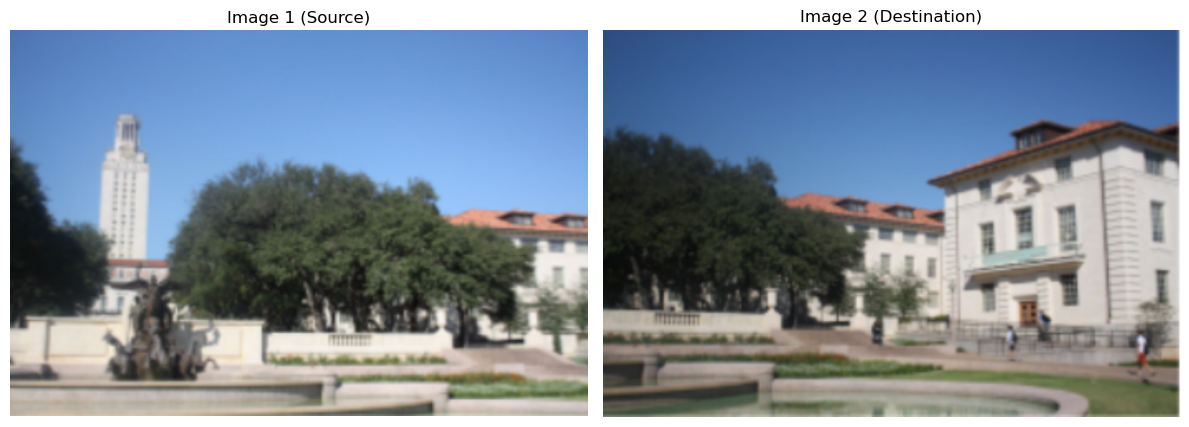

In [20]:
img1 = cv2.imread('image1.png')
img2 = cv2.imread('image2.png')

if img1 is None or img2 is None:
    print("Error: Could not load one or both images. Check the file paths.")
else:
    print("Images loaded successfully.")

h = 500
img1 = cv2.resize(img1, (int(img1.shape[1] * h / img1.shape[0]), h))
img2 = cv2.resize(img2, (int(img2.shape[1] * h / img2.shape[0]), h))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Image 1 (Source)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Image 2 (Destination)')
plt.axis('off')

plt.tight_layout()
plt.show()


## Displays The Final Mosaic

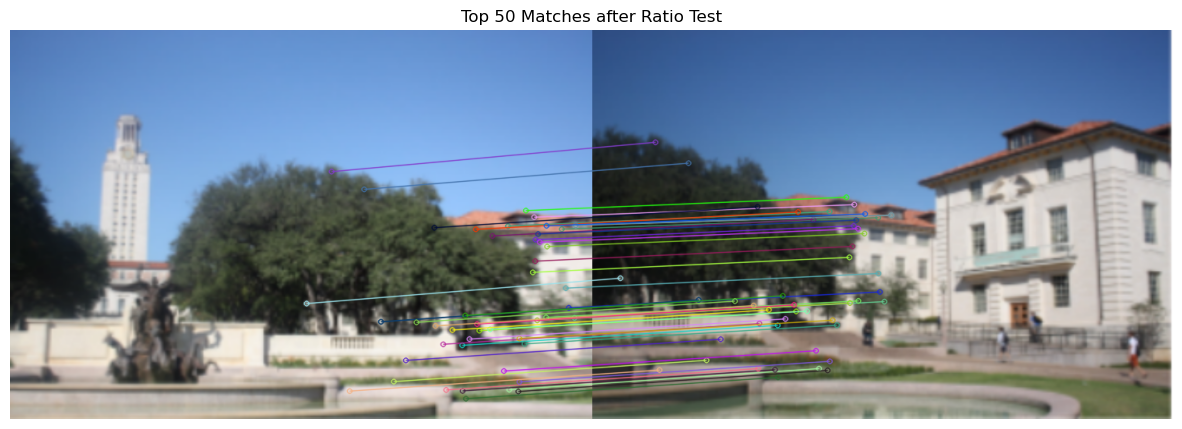

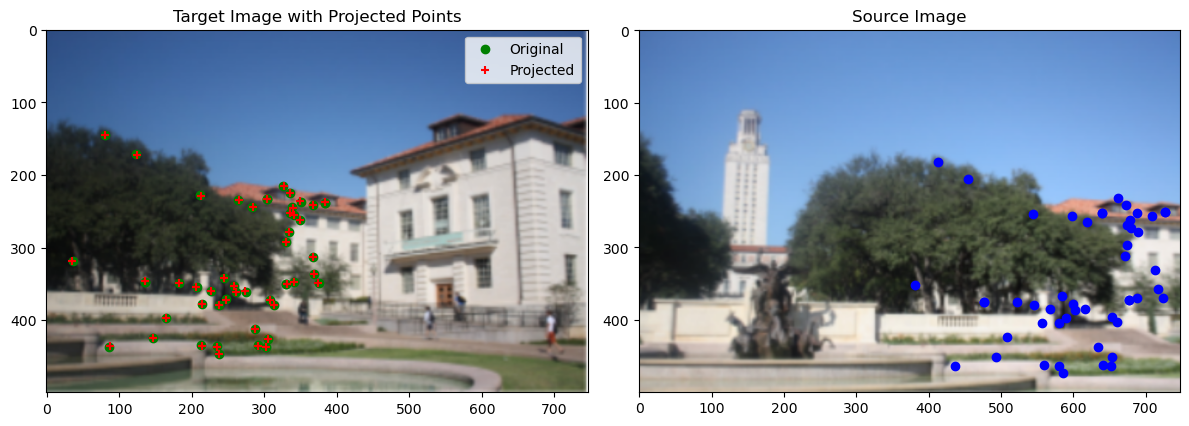

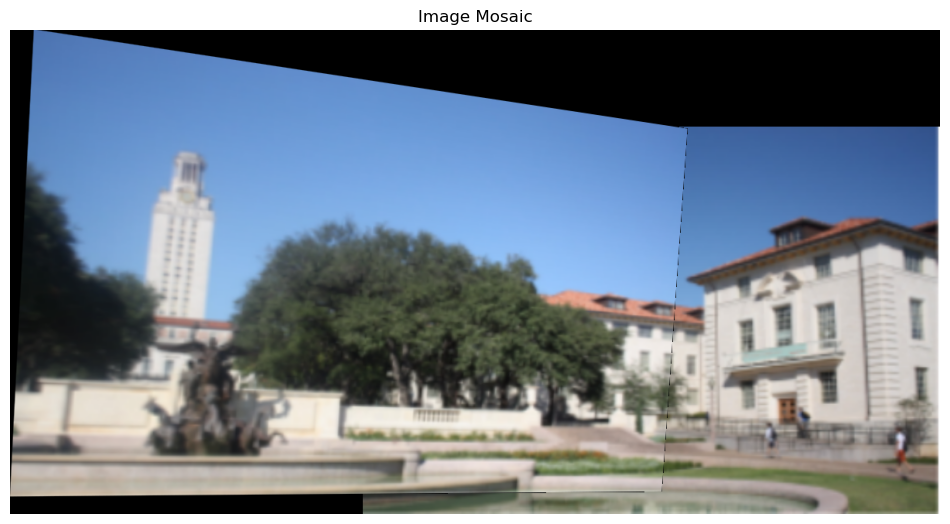

In [21]:
p1, p2 = find_and_draw_matches(img1, img2)

H = compute_homography(p1, p2)
visualize_homography(img1, img2, p1, p2, H)
stitched = stitch(img1, img2, H)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
plt.title("Image Mosaic")
plt.axis("off")
plt.show()
